In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import mne
from functools import reduce
import operator

In [2]:
def get_stcs(subjects_dir, fsave_vertices, directory, sub):
    src_fname = '/Applications/freesurfer/8.0.0/subjects/fsaverage/bem/fsaverage-ico-4-src.fif'
    src = mne.read_source_spaces(src_fname)

    stc_prod_ident = mne.read_source_estimate(directory + sub + '_ident_prod-lh.stc', subject=sub)
    stc_prod_unrel = mne.read_source_estimate(directory + sub + '_unrel_prod-lh.stc', subject=sub)
    stc_comp_ident = mne.read_source_estimate(directory + sub + '_ident_comp-lh.stc', subject=sub)
    stc_comp_unrel = mne.read_source_estimate(directory + sub + '_unrel_comp-lh.stc', subject=sub)

    morph1 = mne.compute_source_morph(
        stc_prod_ident,
        subject_from=sub,
        subject_to='fsaverage',
        src_to=src,
        subjects_dir=subjects_dir)
    morph2 = mne.compute_source_morph(
        stc_prod_unrel,
        subject_from=sub,
        subject_to='fsaverage',
        src_to = src,
        subjects_dir=subjects_dir)
    morph3 = mne.compute_source_morph(
        stc_comp_ident,
        subject_from=sub,
        subject_to='fsaverage',
        src_to = src,
        subjects_dir=subjects_dir)
    morph4 = mne.compute_source_morph(
        stc_comp_unrel,
        subject_from=sub,
        subject_to='fsaverage',
        src_to = src,
        subjects_dir=subjects_dir)

    prod_ident = morph1.apply(stc_prod_ident)
    prod_unrel = morph2.apply(stc_prod_unrel)
    comp_ident = morph3.apply(stc_comp_ident)
    comp_unrel = morph4.apply(stc_comp_unrel)

    return prod_ident, prod_unrel, comp_ident, comp_unrel

In [4]:
def grand_average_stcs(stcs):
    """Average a list of STC objects."""
    data = np.stack([stc.data for stc in stcs], axis=0)  # (n_subjects, n_vertices, n_times)
    avg_data = np.mean(data, axis=0)
    return mne.SourceEstimate(
        avg_data,
        vertices=stcs[0].vertices,
        tmin=stcs[0].tmin,
        tstep=stcs[0].tstep,
        subject=stcs[0].subject
    )

In [5]:
subs = ['R3250', 'R3254', 'R3261', 'R3264', 'R3270','R3271','R3272','R3273','R3275','R3277','R3279','R3285','R3286','R3289','R3290']

n_subjects = len(subs)
subjects_dir = '/Applications/freesurfer/8.0.0/subjects'
src_fname = '/Applications/freesurfer/8.0.0/subjects/fsaverage/bem/fsaverage-ico-4-src.fif'

# arrays where the stcs for each condition will be stored
ident_prod_stcs = []
unrel_prod_stcs = []
ident_comp_stcs = []
unrel_comp_stcs = []

# Reading the source space for fsaverage
src = mne.read_source_spaces(src_fname)
fsave_vertices = [s["vertno"] for s in src]

for sub in subs:
    directory = '/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/' + sub + '/'
    stc_prod_ident_fsavg, stc_prod_unrel_fsavg, stc_comp_ident_fsavg, stc_comp_unrel_fsavg = get_stcs(subjects_dir,
                                                                                                          fsave_vertices, directory, sub)
    tstep = stc_prod_ident_fsavg.tstep * 1000

    ident_prod_stcs.append(stc_prod_ident_fsavg)
    unrel_prod_stcs.append(stc_prod_unrel_fsavg)
    ident_comp_stcs.append(stc_comp_ident_fsavg)
    unrel_comp_stcs.append(stc_comp_unrel_fsavg)

    # Grand average for one condition (you can repeat this for others)
    avg_ident_prod = grand_average_stcs(ident_prod_stcs)
    avg_unrel_prod = grand_average_stcs(unrel_prod_stcs)
    avg_ident_comp = grand_average_stcs(ident_comp_stcs)
    avg_unrel_comp = grand_average_stcs(unrel_comp_stcs)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    5 smooth iterations done.
    5 smooth iterations done.
[done]
[done]
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    5 smooth iterations done.
    5 smooth iterations done.
[done]
[done]
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    5 smooth iterations done.
    5 smooth iterations done.
[done]
[done]
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    5 smooth iterations done.
    5 smooth iterations done.
[done]
[done]
    Readin

In [6]:
def plot_roi_ga(condition_stcs, region="all"):
    labels = mne.read_labels_from_annot(
        'fsaverage', parc='aparc.a2009s', hemi='lh', subjects_dir=subjects_dir
    )
    temporal_labels = ["Temporal",
    ['G_temp_sup-G_T_transv-lh', 'G_temp_sup-Lateral-lh', 'G_temp_sup-Plan_polar-lh',
    'G_temp_sup-Plan_tempo-lh', 'G_temporal_inf-lh', 'G_temporal_middle-lh',
    'Pole_temporal-lh', 'S_temporal_inf-lh', 'S_temporal_sup-lh', 'S_temporal_transverse-lh']]

    frontal_labels = ["Frontal",
    ["G_and_S_frontomargin-lh","G_and_S_precentral-lh","G_front_middle-lh","G_front_sup-lh",
    "G_opercularis-lh","G_orbital-lh","G_subcentral-lh","G_suborbital-lh","Pole_frontal-lh","S_front_inf-lh",
    "S_front_middle-lh","S_orbital_lateral-lh","S_orbital_med-olfact-lh","S_orbital-H_Shaped-lh","S_precentral-inf-part-lh",
    "S_precentral-sup-part-lh","S_subcentral_ant-lh","S_subcentral_post-lh","S_front_sup-lh"]
    ]

    if region != "all":
        if region == "frontal":
            label_now = frontal_labels
        elif region == "temporal":
            label_now = temporal_labels

        label_now_now = reduce(operator.add, [label for label in labels if label.name in label_now[1]])

        timecourses = {}
        for label, stcs in condition_stcs.items():
            # avg_stc = grand_average_stcs(stcs)
            roi_stc = stcs.in_label(label_now_now)
            timecourses[label] = roi_stc.data.mean(axis=0)  # average across vertices
            times = roi_stc.times * 1000  # convert to ms (only need once)
        title = f"{label_now[0]} lobe"
        flip = True
    else:
        timecourses = {}
        for label, stcs in condition_stcs.items():
            # roi_stc = grand_average_stcs(stcs)
            timecourses[label] = stcs.data.mean(axis=0)  # average across vertices
            times = stcs.times * 1000  # convert to ms (only need once)
        title = "all regions "
        flip = False

    # === Step 4: Plot all conditions ===
    plt.figure(figsize=(12, 5))

    for label, timecourse in timecourses.items():
        # Decide color based on task (prod vs comp)
        if "Prod" in label:
            color = "orange"
        elif "Comp" in label:
            color = "blue"
        else:
            color = "gray"  # fallback, just in case

        # Decide linestyle based on prime (ident = primed vs unrel = unprimed)
        if "Ident" in label:
            linestyle = "-"  # dotted
        elif "Unrel" in label:
            linestyle = "--"  # solid
        else:
            linestyle = "--"  # fallback

        plt.plot(times, timecourse * 1e9, label=label, linestyle=linestyle, color=color)  # convert Am to nAm


    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (nAm)')
    plt.title(f"Grand-Averaged Activation in Left Hemisphere {title}")
    plt.axvline(0, color='k', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if flip:
        plt.gca().invert_yaxis()
    plt.show()


In [7]:
comp_dif = avg_unrel_comp - avg_ident_comp
prod_dif = avg_unrel_prod - avg_ident_prod

In [ ]:
brain = comp_dif.plot(
    subjects_dir=subjects_dir,
    hemi='both',
    clim=dict(kind="value", lims=[0.5, 2, 3.5]),
    smoothing_steps=7,
    initial_time=0.4,
    title='Comprehension'
        )
brain.add_text(0.0, 0.3, 'Comprehension', "title", font_size=14)
# brain.add_annotation('aparc')

In [ ]:
brain = prod_dif.plot(
    subjects_dir=subjects_dir,
    hemi='both',
    clim=dict(kind="value", lims=[0.5, 2, 3.5]),
    smoothing_steps=7,
    initial_time=0.4,
    title='Production Difference'
        )
brain.add_text(0.0, 0.3, 'Production Difference', "title", font_size=14)

# Plotting specific regions

Reading labels from parcellation...
   read 75 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/lh.aparc.a2009s.annot


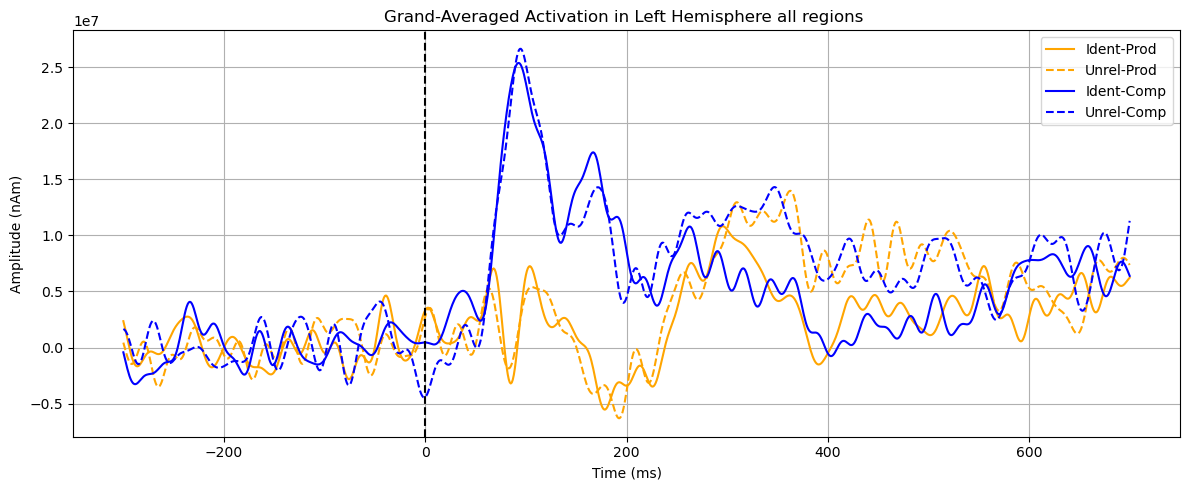

In [7]:
condition_stcs = {
    'Ident-Prod': avg_ident_prod,
    'Unrel-Prod': avg_unrel_prod,
    'Ident-Comp': avg_ident_comp,
    'Unrel-Comp': avg_unrel_comp
}

# condition_stcs = {
#     "Production Difference (unprime-prime)": prod_dif,
#     "Comprehension Difference (unprime-prime)": comp_dif
# }

plot_roi_ga(condition_stcs, "all")

In [20]:
labels = mne.read_labels_from_annot(
    subject='fsaverage',
    parc='aparc',  # could also use 'aparc.a2009s'
    subjects_dir=subjects_dir
)

temporal_labels = [lab for lab in labels if 'temporal' in lab.name.lower() or 'sts' in lab.name.lower()]\

frontal_labels = frontal_labels = [
    lab for lab in labels
    if any(k in lab.name.lower() for k in ['frontal', 'orbitofrontal'])
]


Reading labels from parcellation...
   read 35 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/lh.aparc.annot
   read 34 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/rh.aparc.annot


In [21]:
stc_temporal_prod = prod_dif.in_label(temporal_labels[0])

stc_temporal_comp = comp_dif.in_label(temporal_labels[0])

stc_frontal_prod = prod_dif.in_label(frontal_labels[0])

stc_frontal_comp = comp_dif.in_label(frontal_labels[0])

In [17]:
brain = stc_temporal_prod.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    clim=dict(kind="value", lims=[0, 1, 2]),
    smoothing_steps=7,
    title='Production',
    background='white',
    show_traces=False
        )
brain.add_text(0.4, 0.9, 'Production', "title", font_size=14)

Using pyvistaqt 3d backend.


2025-09-02 11:07:46.904 python[41800:9835626] +[IMKClient subclass]: chose IMKClient_Modern
2025-09-02 11:07:46.904 python[41800:9835626] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [18]:
brain = stc_temporal_comp.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    clim=dict(kind="value", lims=[0, 1, 2]),
    smoothing_steps=7,
    title='Comprehension',
    background='white',
    show_traces=False
        )
# brain.add_annotation("aparc")
brain.add_text(0.4, 0.9, 'Comprehension', "title", font_size=14)

In [24]:
brain = stc_frontal_prod.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    clim=dict(kind="value", lims=[0, 1, 2]),
    smoothing_steps=7,
    title='Production',
    background='white',
    show_traces=False
        )
brain.add_text(0.4, 0.9, 'Production', "title", font_size=14)

In [28]:
brain = stc_frontal_comp.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    clim=dict(kind="value", lims=[0, 1, 2]),
    smoothing_steps=7,
    title='Comprehension',
    background='white',
    show_traces=False,
    initial_time = 200
        )
brain.add_text(0.4, 0.9, 'Comprehension', "title", font_size=14)